#### Для запуска нужно скачать публично доступную сеть DFNet https://drive.google.com/drive/folders/1lKJg__prvJTOdgmg9ZDF9II8B1C3YSkN и положить `model_places2.pth` в корень репозитория

In [1]:
!pip install -r requirements.txt --user

  Cloning https://github.com/albu/albumentations.git to /tmp/pip-req-build-ufn4zxtx
  Running command git clone -q https://github.com/albu/albumentations.git /tmp/pip-req-build-ufn4zxtx
  Stored in directory: /tmp/pip-ephem-wheel-cache-bb8vaa9l/wheels/1e/ea/2b/85eb550a120aa7301f3709546a6338f983395a44369e7aff2c
Successfully built albumentations
  Found existing installation: albumentations 0.3.0
    Uninstalling albumentations-0.3.0:
      Successfully uninstalled albumentations-0.3.0


In [6]:
img_dir = 'test_final' # путь к директории с тестовыми картинками

In [7]:
import sys
sys.path.insert(0, './DFNet')

import torch
import numpy as np
from pathlib import Path
import matplotlib.pylab as plt
%matplotlib inline

from albumentations import PadIfNeeded, Compose, Rotate
from torch.utils.data import Dataset, DataLoader
from model import DFNet, InpaintWrapper
from dataset import InpaintingDataset, FinalDataset
from utils import ToTensor,to_numpy,FixedRotate
from tqdm import tqdm_notebook
from albumentations import CenterCrop
import torch
import numpy as np
from pathlib import Path
from albumentations import PadIfNeeded, Compose, Rotate
from torch.utils.data import Dataset, DataLoader
from model import DFNet, InpaintWrapper
from dataset import InpaintingDataset
from utils import ToTensor,to_numpy,FixedRotate
from tqdm import tqdm_notebook
from PIL import Image
import os

In [8]:
img_dir = Path(img_dir)

test_filenames = [os.path.join(img_dir, '{}.png'.format(i)) for i in range(200)]
test_images = np.stack([
    np.asarray(Image.open(f)) for f in tqdm_notebook(test_filenames)
])

In [9]:
white_space = test_images.mean(axis=-1)==255

from skimage.morphology import binary_opening, disk, square, diamond
from skimage import measure

def threshold_by_area(mask, threshold = 2000, top_threshold= 50000):
    label = measure.label(mask)
    classes, counts = np.unique(label, return_counts=True)
    classes = classes[(counts>threshold) & (counts<top_threshold) ]
    new_mask = np.zeros_like(mask, dtype=bool)
    for c in classes:
        if c!=0:
            new_mask[label==c] = 1
    return new_mask

from joblib import Parallel, delayed
process = lambda mask : threshold_by_area(binary_opening(mask, square(31)), 2200)
test_masks = Parallel(n_jobs=-1)(delayed(process)(mask) for mask in tqdm_notebook(white_space))

test_masks = np.stack(test_masks)

In [10]:
!mkdir final_test_masks

In [11]:
from skimage.io import imsave
import os

for name, img in tqdm_notebook(zip(test_filenames, test_masks), total=len(test_masks)):
    imsave('final_test_masks/'+os.path.basename(name), img.astype('uint8')*255)

/home/jupyter-monty/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: final_test_masks/96.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [14]:
mask_dir = Path('final_test_masks')

checkpoint_path = 'model_places2.pth'
device = 'cuda'

model = DFNet().to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

model = InpaintWrapper(model)

In [15]:
BATCH_SIZE = 4

def inpaint_with_augmentation(model, inpaint_dataset, reconstruction_dataset, aug=None, reverse_aug=None):
    aug = [] if aug is None else aug
    reverse_aug = [] if reverse_aug is None else reverse_aug
    
    transform = Compose([PadIfNeeded(min_height=768, min_width=768)] + aug + [ToTensor()])
    reverse_transform =  Compose(reverse_aug+ [CenterCrop(600,500)])
    
    inpaint_dataset.transform = transform
    loader = DataLoader(inpaint_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 16)
    results = np.zeros((len(inpaint_dataset),  600, 500, 3), dtype='uint8')
    
    idx = 0
    for imgs, masks in tqdm_notebook(loader, total=len(loader)):
        inpainted = model(imgs.to(device), masks.to(device))
        inpainted = to_numpy(inpainted)
        for im in inpainted:
            results[idx] = reverse_transform(image=im)['image']
            idx += 1
    
    for (i, inpainted), (orig, mask) in zip(enumerate(results), reconstruction_dataset):
        mask =  np.stack([mask>0]*3, axis=-1).astype(float)
        inpainted = orig * mask + inpainted * (1-mask)
        results[i] = inpainted.astype('uint8')
    return results

In [16]:
inpaint_dataset = FinalDataset(img_dir, mask_dir, expand_mask=3)
reconstruction_dataset = FinalDataset(img_dir, mask_dir)

preinpaint = inpaint_with_augmentation(model, inpaint_dataset, reconstruction_dataset)

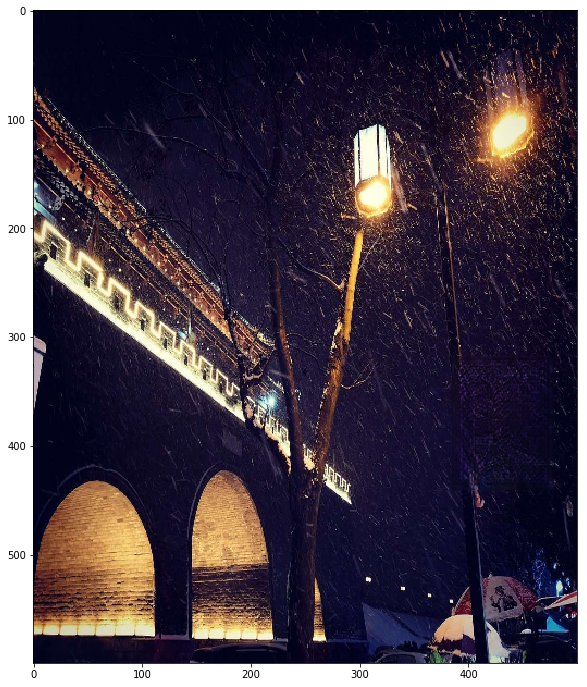

In [4]:
plt.figure(figsize=(12,12))
plt.imshow(preinpaint[10]) 

In [17]:
!rm -rf preinpainted
!mkdir preinpainted

In [18]:
from skimage.io import imsave
import os


for name, img in tqdm_notebook(zip(inpaint_dataset.indices, preinpaint), total=len(preinpaint)):
    imsave('preinpainted/'+name+'.png', img)

In [19]:
from albumentations import HorizontalFlip

In [20]:
from itertools import chain
augs, reverse_augs = [], []
shifts = [7,30,60,82, 15, 45, 75, 37, 53]

angles = list(chain(*([s, 90+s,180+s, 210+s] for s in shifts)))
for a in angles:
    augs.append([FixedRotate(a)])
    reverse_augs.append([FixedRotate(-a)])
    
    augs.append([HorizontalFlip(always_apply=True, p=1), FixedRotate(a)])
    reverse_augs.append([FixedRotate(-a), HorizontalFlip(always_apply=True, p=1)])
    

    
inpaint_dataset = FinalDataset('preinpainted', mask_dir)
reconstruction_dataset = FinalDataset('preinpainted', mask_dir)

all_results = []
for angle, aug, reverse_aug in zip(angles, augs, reverse_augs):
    results = inpaint_with_augmentation(model, inpaint_dataset, reconstruction_dataset, aug, reverse_aug,)
    all_results.append(results)

In [21]:
all_results = np.stack(all_results)

In [22]:
from multiprocessing import Pool, cpu_count
import cv2

In [23]:
def work(im):
    return cv2.GaussianBlur(im, (9, 9), 0)

In [24]:
with Pool(cpu_count()) as pool:
    blured = list(tqdm_notebook(
        pool.imap(work, all_results.reshape((-1,) + all_results.shape[2:])),
        total = all_results.shape[0] * all_results.shape[1]
    ))

In [25]:
blured = np.stack(blured).reshape(all_results.shape)

In [26]:
results = blured.astype(float).mean(0)

In [27]:
for (i, inpainted), (orig, mask) in zip(enumerate(results), reconstruction_dataset):
    mask =  np.stack([mask>0]*3, axis=-1).astype(float)
    inpainted = orig * mask + inpainted * (1-mask)
    results[i] = inpainted

In [28]:
results = results.astype('uint8')

In [29]:
results.shape

(200, 600, 500, 3)

In [30]:
!rm -rf result
!mkdir result

In [31]:
from skimage.io import imsave
import os

for name, img in tqdm_notebook(zip(inpaint_dataset.indices, results), total=len(results)):
    imsave('result/'+name+'.png', img)

In [32]:
!rm result.zip
!zip -j -r -D result.zip result

rm: cannot remove 'result.zip': No such file or directory
  adding: 149.png (deflated 0%)
  adding: 56.png (deflated 0%)
  adding: 142.png (deflated 0%)
  adding: 96.png (deflated 0%)
  adding: 146.png (deflated 0%)
  adding: 155.png (deflated 0%)
  adding: 187.png (deflated 0%)
  adding: 144.png (deflated 0%)
  adding: 191.png (deflated 0%)
  adding: 159.png (deflated 0%)
  adding: 46.png (deflated 0%)
  adding: 29.png (deflated 0%)
  adding: 48.png (deflated 0%)
  adding: 107.png (deflated 0%)
  adding: 86.png (deflated 0%)
  adding: 148.png (deflated 0%)
  adding: 192.png (deflated 0%)
  adding: 41.png (deflated 0%)
  adding: 188.png (deflated 0%)
  adding: 28.png (deflated 0%)
  adding: 175.png (deflated 0%)
  adding: 66.png (deflated 0%)
  adding: 171.png (deflated 0%)
  adding: 120.png (deflated 0%)
  adding: 161.png (deflated 0%)
  adding: 69.png (deflated 0%)
  adding: 189.png (deflated 0%)
  adding: 74.png (deflated 0%)
  adding: 47.png (deflated 0%)
  adding: 95.png (deflated